<a href="https://colab.research.google.com/github/dany-gaga/DGE_analysis/blob/main/snpeff_vcf_to_downstream_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# run this code to mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
import joblib
from xgboost import plot_tree
import matplotlib.pyplot as plt
from yellowbrick.regressor import ResidualsPlot
from sklearn.inspection import plot_partial_dependence
from sklearn.metrics import mean_squared_error


In [ ]:
%cd /content/gdrive/MyDrive/from_snpeff-vcf_to_downstream_analysis

/content/gdrive/MyDrive/from_snpeff-vcf_to_downstream_analysis


In [ ]:
alls = pd.read_csv('/content/gdrive/MyDrive/from_snpeff-vcf_to_downstream_analysis/all_snpeff_dge_stat.csv')

In [ ]:
alt = pd.read_csv('/content/gdrive/MyDrive/from_snpeff-vcf_to_downstream_analysis/aa_meta_for_alt.csv')
ref = pd.read_csv('/content/gdrive/MyDrive/from_snpeff-vcf_to_downstream_analysis/aa_meta_for_ref.csv')

In [ ]:
alls.columns

Index(['genome', 'POS', 'REF', 'ALT', 'effect', 'impact', 'gene', 'mut_cdna',
       'mut_aa', 'pos_cdna', 'pos_aa', 'in_gene', 'mut_type',
       'nuc_pos_in_gene', 'aa_pos_in_gene', 'aa_ref', 'aa_alt', 'Name', 'Gene',
       'logFC', 'FDR', 'Description_Blast2GO'],
      dtype='object')

In [ ]:
alt.columns


Index(['Abbreviation', 'Importance_alt', 'R-group chemistry_alt',
       'Hydrophobic_alt', 'pH_alt', 'Aromatic or aliphatic_alt',
       'alpha helix_alt', 'Reverse turn_alt', 'beta sheet_alt',
       'Hydropathy score_alt'],
      dtype='object')

In [ ]:
alls_alt = pd.merge(alls, alt, left_on='aa_alt', right_on='Abbreviation', how='left')

In [ ]:
alls_alt_ref = pd.merge(alls_alt, ref, left_on='aa_ref', right_on='Abbreviation', how='left')


In [ ]:
alls_alt_ref.columns

Index(['genome', 'POS', 'REF', 'ALT', 'effect', 'impact', 'gene', 'mut_cdna',
       'mut_aa', 'pos_cdna', 'pos_aa', 'in_gene', 'mut_type',
       'nuc_pos_in_gene', 'aa_pos_in_gene', 'aa_ref', 'aa_alt', 'Name', 'Gene',
       'logFC', 'FDR', 'Description_Blast2GO', 'Abbreviation_x',
       'Importance_alt', 'R-group chemistry_alt', 'Hydrophobic_alt', 'pH_alt',
       'Aromatic or aliphatic_alt', 'alpha helix_alt', 'Reverse turn_alt',
       'beta sheet_alt', 'Hydropathy score_alt', 'Abbreviation_y',
       'Importance_ref', 'R-group chemistry_ref', 'Hydrophobic_ref', 'pH_ref',
       'Aromatic or aliphatic_ref', 'alpha helix_ref', 'Reverse turn_ref',
       'beta sheet_ref', 'Hydropathy score_ref'],
      dtype='object')

In [ ]:
alls_alt_ref = alls_alt_ref.drop(['REF', 'ALT', 'effect', 'impact', 'gene', 'mut_cdna',
       'mut_aa', 'pos_cdna', 'pos_aa', 'in_gene'], axis=1)

In [ ]:
alls_alt_ref

,genome,POS,mut_type,nuc_pos_in_gene,aa_pos_in_gene,aa_ref,aa_alt,Name,Gene,logFC,...,Abbreviation_y,Importance_ref,R-group chemistry_ref,Hydrophobic_ref,pH_ref,Aromatic or aliphatic_ref,alpha helix_ref,Reverse turn_ref,beta sheet_ref,Hydropathy score_ref
0,AgamP4_2L,181108,snp,106,36,Lys,Gln,BD01_S9,AGAP004677,0.029656,...,Lys,Essential,Amine,False,Basic,None,1.23,1.07,0.69,-3.9
1,AgamP4_2L,181138,snp,76,26,Ile,Val,BD01_S9,AGAP004677,0.029656,...,Ile,Essential,Non-polar,True,Neutral,Aliphatic,1.09,0.47,1.67,4.5
2,AgamP4_2L,204387,snp,466,156,Ile,Val,BD01_S9,AGAP004678,-1.406740,...,Ile,Essential,Non-polar,True,Neutral,Aliphatic,1.09,0.47,1.67,4.5
3,AgamP4_2L,204516,complex,595_597,199,Ile,Val,BD01_S9,AGAP004678,-1.406740,...,Ile,Essential,Non-polar,True,Neutral,Aliphatic,1.09,0.47,1.67,4.5
4,AgamP4_2L,204529,snp,608,203,Ala,Glu,BD01_S9,AGAP004678,-1.406740,...,Ala,Non-essential,Non-polar,True,Neutral,None,1.41,0.82,0.72,1.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1689548,AgamP4_Mt,10889,snp,477,159,Met,Ile,DU03_S1,AGAP028387,0.759333,...,Met,Essential,Non-polar,True,Neutral,None,1.30,0.52,1.14,1.9
1689549,AgamP4_Mt,10971,snp,559,187,Pro,Ser,DU03_S1,AGAP028387,0.759333,...,Pro,Non-essential,Non-polar,True,Neutral,None,0.34,1.32,0.31,-1.6
1689550,AgamP4_Mt,11975,snp,601,201,Thr,Ala,DU03_S1,AGAP028389,0.539925,...,Thr,Essential,Hydroxyl,False,Weak acidic,None,0.76,0.96,1.17,-0.7
1689551,AgamP4_Mt,12061,snp,515,172,Phe,Ser,DU03_S1,AGAP028389,0.539925,...,Phe,Essential,Aromatic,True,Neutral,Aromatic,1.16,0.59,1.33,2.8


In [ ]:
alls_alt_ref['Hydropathy_difference'] = alls_alt_ref['Hydropathy score_alt'] - alls_alt_ref['Hydropathy score_ref']

alls_alt_ref['alpha_helix_difference'] = alls_alt_ref['alpha helix_alt'] - alls_alt_ref['alpha helix_ref']

alls_alt_ref['Reverse_turn_difference'] = alls_alt_ref['Reverse turn_alt'] - alls_alt_ref['Reverse turn_ref']

alls_alt_ref['beta_sheet_difference'] = alls_alt_ref['beta sheet_alt'] - alls_alt_ref['beta sheet_ref']

In [ ]:
alls_alt_ref.columns

Index(['genome', 'POS', 'mut_type', 'nuc_pos_in_gene', 'aa_pos_in_gene',
       'aa_ref', 'aa_alt', 'Name', 'Gene', 'logFC', 'FDR',
       'Description_Blast2GO', 'Abbreviation_x', 'Importance_alt',
       'R-group chemistry_alt', 'Hydrophobic_alt', 'pH_alt',
       'Aromatic or aliphatic_alt', 'alpha helix_alt', 'Reverse turn_alt',
       'beta sheet_alt', 'Hydropathy score_alt', 'Abbreviation_y',
       'Importance_ref', 'R-group chemistry_ref', 'Hydrophobic_ref', 'pH_ref',
       'Aromatic or aliphatic_ref', 'alpha helix_ref', 'Reverse turn_ref',
       'beta sheet_ref', 'Hydropathy score_ref', 'Hydropathy_difference',
       'alpha_helix_difference', 'Reverse_turn_difference',
       'beta_sheet_difference'],
      dtype='object')

In [ ]:
alls_alt_ref = pd.get_dummies(alls_alt_ref, columns=['Importance_alt', 'R-group chemistry_alt', 'Hydrophobic_alt', 'pH_alt',
       'Aromatic or aliphatic_alt', 'Importance_ref', 'R-group chemistry_ref', 'Hydrophobic_ref', 'pH_ref',
       'Aromatic or aliphatic_ref'])

In [ ]:
label_encoder = LabelEncoder()

In [ ]:
alls_alt_ref['genome1'] = label_encoder.fit_transform(alls_alt_ref['genome'])



In [ ]:
alls_alt_ref['Name1'] = label_encoder.fit_transform(alls_alt_ref['Name'])
alls_alt_ref['Gene1'] = label_encoder.fit_transform(alls_alt_ref['Gene'])


In [ ]:
alls_alt_ref['mut_type1'] = label_encoder.fit_transform(alls_alt_ref['mut_type'])

In [ ]:
alls_alt_ref['aa_ref1'] = label_encoder.fit_transform(alls_alt_ref['aa_ref'])
alls_alt_ref['aa_alt1'] = label_encoder.fit_transform(alls_alt_ref['aa_alt'])

In [ ]:
alls_alt_ref

,genome,POS,mut_type,nuc_pos_in_gene,aa_pos_in_gene,aa_ref,aa_alt,Name,Gene,logFC,...,pH_ref_Weak basic,Aromatic or aliphatic_ref_Aliphatic,Aromatic or aliphatic_ref_Aromatic,Aromatic or aliphatic_ref_None,genome1,Name1,Gene1,mut_type1,aa_ref1,aa_alt1
0,AgamP4_2L,181108,snp,106,36,Lys,Gln,BD01_S9,AGAP004677,0.029656,...,0,0,0,1,0,0,3394,98,478,209
1,AgamP4_2L,181138,snp,76,26,Ile,Val,BD01_S9,AGAP004677,0.029656,...,0,1,0,0,0,0,3394,98,412,739
2,AgamP4_2L,204387,snp,466,156,Ile,Val,BD01_S9,AGAP004678,-1.406740,...,0,1,0,0,0,0,3395,98,412,739
3,AgamP4_2L,204516,complex,595_597,199,Ile,Val,BD01_S9,AGAP004678,-1.406740,...,0,1,0,0,0,0,3395,0,412,739
4,AgamP4_2L,204529,snp,608,203,Ala,Glu,BD01_S9,AGAP004678,-1.406740,...,0,0,0,1,0,0,3395,98,1,266
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1689548,AgamP4_Mt,10889,snp,477,159,Met,Ile,DU03_S1,AGAP028387,0.759333,...,0,0,0,1,4,20,9242,98,511,403
1689549,AgamP4_Mt,10971,snp,559,187,Pro,Ser,DU03_S1,AGAP028387,0.759333,...,0,0,0,1,4,20,9242,98,566,612
1689550,AgamP4_Mt,11975,snp,601,201,Thr,Ala,DU03_S1,AGAP028389,0.539925,...,0,0,0,1,4,20,9243,98,650,0
1689551,AgamP4_Mt,12061,snp,515,172,Phe,Ser,DU03_S1,AGAP028389,0.539925,...,0,0,1,0,4,20,9243,98,546,612


In [ ]:
alls_alt_ref.columns


Index(['genome', 'POS', 'mut_type', 'nuc_pos_in_gene', 'aa_pos_in_gene',
       'aa_ref', 'aa_alt', 'Name', 'Gene', 'logFC', 'FDR',
       'Description_Blast2GO', 'Abbreviation_x', 'alpha helix_alt',
       'Reverse turn_alt', 'beta sheet_alt', 'Hydropathy score_alt',
       'Abbreviation_y', 'alpha helix_ref', 'Reverse turn_ref',
       'beta sheet_ref', 'Hydropathy score_ref', 'Hydropathy_difference',
       'alpha_helix_difference', 'Reverse_turn_difference',
       'beta_sheet_difference', 'Importance_alt_Essential',
       'Importance_alt_Non-essential', 'R-group chemistry_alt_Amine',
       'R-group chemistry_alt_Aromatic', 'R-group chemistry_alt_Carboxyl',
       'R-group chemistry_alt_Hydroxyl', 'R-group chemistry_alt_Non-polar',
       'R-group chemistry_alt_Other', 'Hydrophobic_alt_False',
       'Hydrophobic_alt_True', 'pH_alt_Acidic', 'pH_alt_Basic',
       'pH_alt_Neutral', 'pH_alt_Strongly basic', 'pH_alt_Weak acidic',
       'pH_alt_Weak basic', 'Aromatic or aliphatic_al

In [ ]:
alls_alt_ref = alls_alt_ref.drop(['genome', 'Description_Blast2GO', 'mut_type', 'nuc_pos_in_gene', 'aa_pos_in_gene',
       'aa_ref', 'aa_alt', 'Name', 'Gene','Abbreviation_x',
       'alpha helix_alt', 'Reverse turn_alt', 'beta sheet_alt',
       'Hydropathy score_alt', 'Abbreviation_y', 'alpha helix_ref',
       'Reverse turn_ref', 'beta sheet_ref', 'Hydropathy score_ref'], axis=1)

In [ ]:
alls_alt_ref.columns

Index(['POS', 'logFC', 'FDR', 'Hydropathy_difference',
       'alpha_helix_difference', 'Reverse_turn_difference',
       'beta_sheet_difference', 'Importance_alt_Essential',
       'Importance_alt_Non-essential', 'R-group chemistry_alt_Amine',
       'R-group chemistry_alt_Aromatic', 'R-group chemistry_alt_Carboxyl',
       'R-group chemistry_alt_Hydroxyl', 'R-group chemistry_alt_Non-polar',
       'R-group chemistry_alt_Other', 'Hydrophobic_alt_False',
       'Hydrophobic_alt_True', 'pH_alt_Acidic', 'pH_alt_Basic',
       'pH_alt_Neutral', 'pH_alt_Strongly basic', 'pH_alt_Weak acidic',
       'pH_alt_Weak basic', 'Aromatic or aliphatic_alt_Aliphatic',
       'Aromatic or aliphatic_alt_Aromatic', 'Aromatic or aliphatic_alt_None',
       'Importance_ref_Essential', 'Importance_ref_Non-essential',
       'R-group chemistry_ref_Amine', 'R-group chemistry_ref_Aromatic',
       'R-group chemistry_ref_Carboxyl', 'R-group chemistry_ref_Hydroxyl',
       'R-group chemistry_ref_Non-polar', 'R-

In [ ]:
#
alls_alt_ref.to_csv('alls_alt_ref.csv')

# **Let's start from here**

In [ ]:
alls_alt_ref = pd.read_csv('alls_alt_ref.csv')

In [ ]:
X = alls_alt_ref.drop('logFC', axis=1)
y = alls_alt_ref['logFC']

In [ ]:
X_clean = X.dropna()
y_clean = y[X.index.isin(X_clean.index)]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_clean, y_clean, test_size=0.4, random_state=42)


In [ ]:
model = RandomForestRegressor()

In [ ]:
model.fit(X_train, y_train)

RandomForestRegressor()

In [ ]:
import joblib

In [ ]:
# Save the trained model to a file
joblib.dump(model, 'trained_model_rfr.pkl')

['trained_model_rfr.pkl']

In [ ]:
# Load the saved model
# model = joblib.load('/content/gdrive/MyDrive/from_snpeff-vcf_to_downstream_analysis/trained_model_rfr.pkl')

In [ ]:
# Use the model for predictions
y_pred = model.predict(X_test)

In [ ]:
y_pred


array([ 1.39838431,  0.41148192,  0.33892018, ...,  0.77289841,
       -0.78059373,  0.65405273])

In [ ]:
mse = mean_squared_error(y_test, y_pred)

print("Mean Squared Error:", mse)

Mean Squared Error: 0.008698190392483608


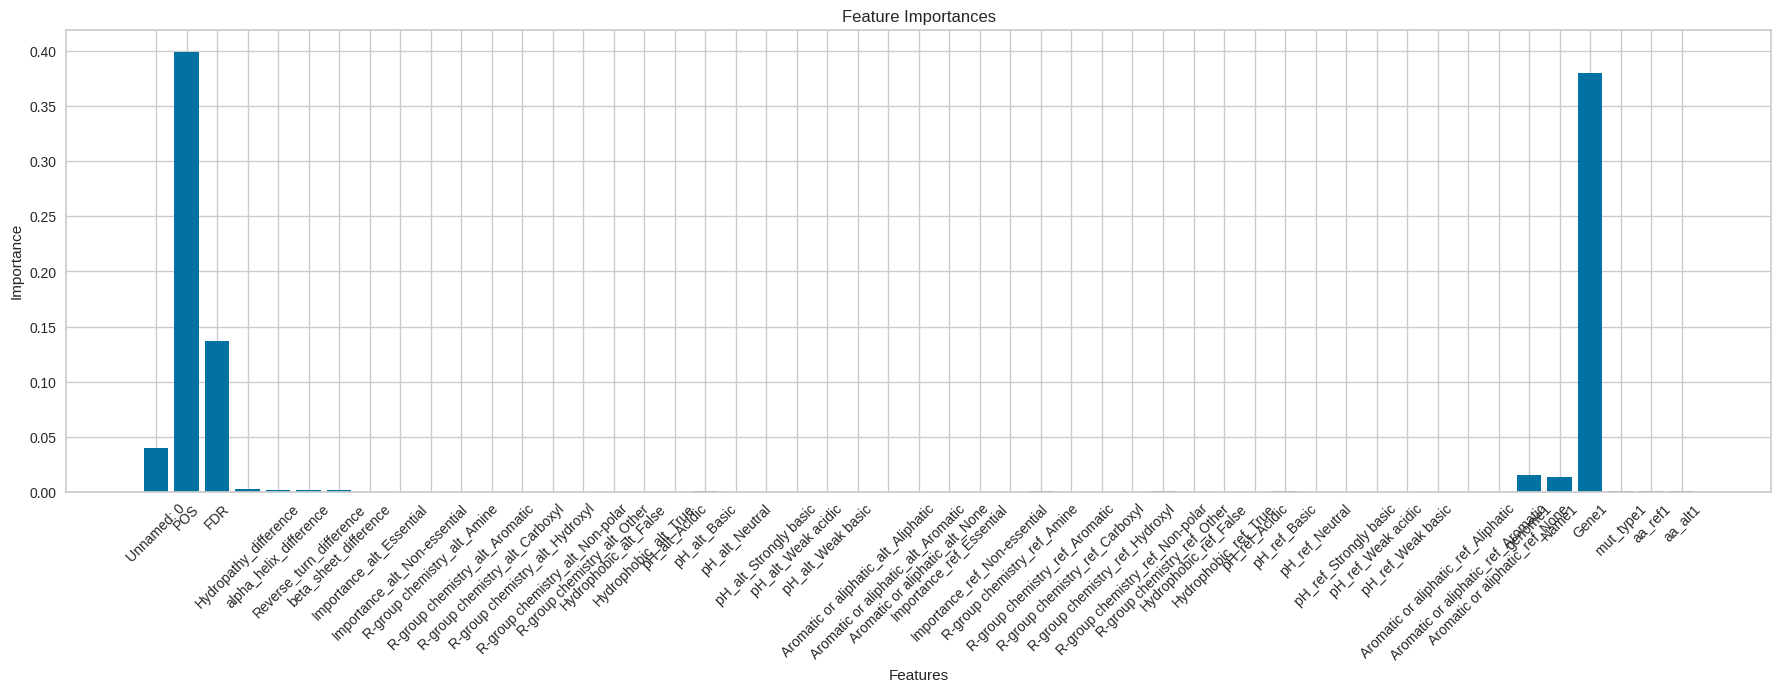

In [ ]:
feature_importances = model.feature_importances_

features = X.columns

plt.figure(figsize=(22, 6))

plt.bar(features, feature_importances)

plt.xlabel('Features')

plt.ylabel('Importance')

plt.title('Feature Importances')

plt.xticks(rotation=45)

plt.show()

In [ ]:
feature_importance = model.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
print(feature_importance_df)

                                Feature  Importance
0                            Unnamed: 0    0.040133
1                                   POS    0.399465
2                                   FDR    0.136599
3                 Hydropathy_difference    0.002117
4                alpha_helix_difference    0.001967
5               Reverse_turn_difference    0.002051
6                 beta_sheet_difference    0.001774
7              Importance_alt_Essential    0.000090
8          Importance_alt_Non-essential    0.000079
9           R-group chemistry_alt_Amine    0.000112
10       R-group chemistry_alt_Aromatic    0.000182
11       R-group chemistry_alt_Carboxyl    0.000171
12       R-group chemistry_alt_Hydroxyl    0.000094
13      R-group chemistry_alt_Non-polar    0.000077
14          R-group chemistry_alt_Other    0.000182
15                Hydrophobic_alt_False    0.000070
16                 Hydrophobic_alt_True    0.000052
17                        pH_alt_Acidic    0.000112
18          

In [ ]:
feature_importances = model.feature_importances_

In [ ]:
sorted_idx = np.argsort(feature_importances)[::-1]

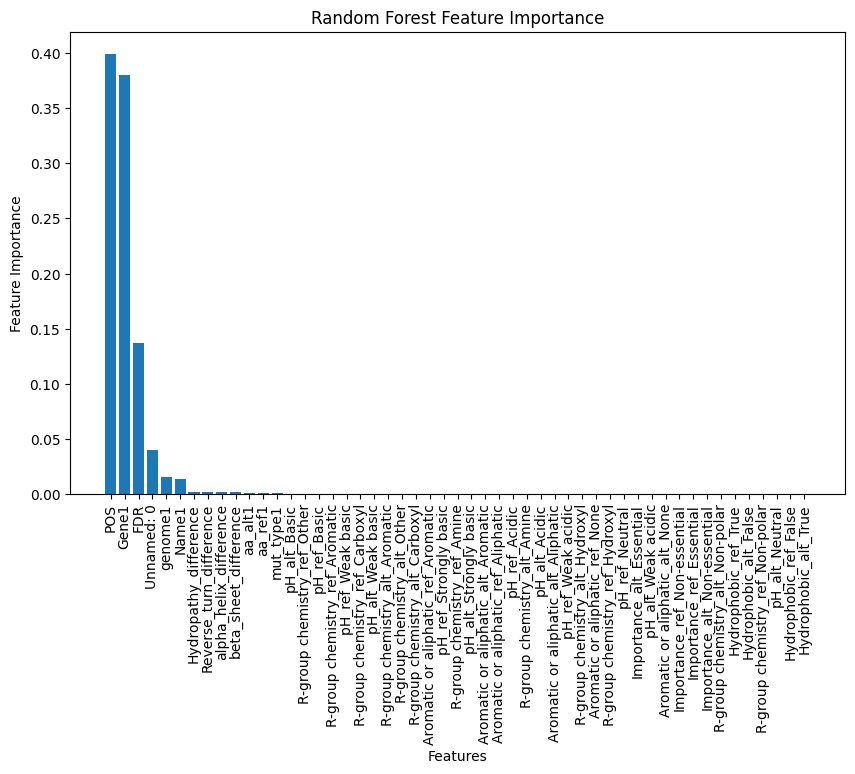

In [ ]:
plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_idx)), feature_importances[sorted_idx])
plt.xticks(range(len(sorted_idx)), np.array(X.columns)[sorted_idx], rotation=90)
plt.xlabel('Features')
plt.ylabel('Feature Importance')
plt.title('Random Forest Feature Importance')
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


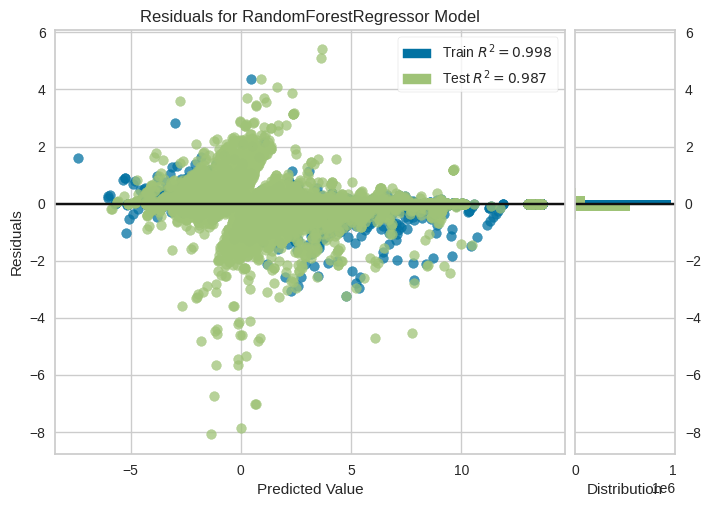

<Axes: title={'center': 'Residuals for RandomForestRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [ ]:
from yellowbrick.regressor import ResidualsPlot

visualizer = ResidualsPlot(model)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()


In [ ]:
from sklearn.inspection import PartialDependenceDisplay

In [ ]:
from sklearn.inspection import partial_dependence

In [ ]:
pd_results = partial_dependence(model, X_train, features=0, kind="average", grid_resolution=5)

In [ ]:
deciles = {0: np.linspace(0, 1, num=5)}
display = PartialDependenceDisplay([pd_results], features=features, feature_names=feature_names, target_idx=0, deciles=deciles)
display.plot(pdp_lim={1: (-1.38, 0.66)})

plt.show()

TypeError: object of type 'int' has no len()

In [ ]:

features = [0, 1]  # Select the features for the partial dependence plot
plot_partial_dependence(model, X_train, features, grid_resolution=50)
plt.suptitle('Partial Dependence Plot')
plt.show()

TypeError: PartialDependenceDisplay.__init__() takes 2 positional arguments but 4 were given

A new chapter

In [ ]:
hist_gb_model = HistGradientBoostingRegressor()
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=0.4, random_state=42)

hist_gb_model.fit(X_train1, y_train1)

In [ ]:
hist_gb_model.predict(X_test1)

In [ ]:
vcf_bdo2 = pd.read_csv('bdo2_ingene.csv')

In [ ]:
vcf_bdo2.columns

Index(['Unnamed: 0', 'genome', 'POS', 'REF', 'ALT', 'effect', 'impact', 'gene',
       'gene_name', 'mut_cdna', 'mut_aa', 'pos_cdna', 'pos_aa', 'in_gene'],
      dtype='object')

In [ ]:
fields = ['genome', 'POS', 'REF', 'ALT', 'effect', 'impact', 'gene','mut_cdna', 'mut_aa', 'pos_cdna', 'pos_aa', 'in_gene']

vcf_bdo2 = pd.read_csv('bdo2_ingene.csv', usecols=fields)


In [ ]:
vcf_bdo2 = vcf_bdo2.loc[vcf_bdo2['in_gene'] ==True]

In [ ]:
# prompt: create new dataframe with only effect == missense_variant

vcf_bdo2_missense = vcf_bdo2.loc[vcf_bdo2['effect']=='missense_variant']


In [ ]:
vcf_bdo2_missense

,genome,POS,REF,ALT,effect,impact,gene,mut_cdna,mut_aa,pos_cdna,pos_aa,in_gene
0,AgamP4_2L,18715,CTT,ATC,missense_variant,MODERATE,AGAP029842,725_727delCTTinsATC,AlaPhe242AspLeu,1223/1295,242/253,True
2,AgamP4_2L,159233,C,T,missense_variant,MODERATE,AGAP004677,439G>A,Asp147Asn,616/1552,147/408,True
3,AgamP4_2L,181108,T,G,missense_variant,MODERATE,AGAP004677,106A>C,Lys36Gln,283/1552,36/408,True
4,AgamP4_2L,181138,T,C,missense_variant,MODERATE,AGAP004677,76A>G,Ile26Val,253/1552,26/408,True
8,AgamP4_2L,204387,A,G,missense_variant,MODERATE,AGAP004678,466A>G,Ile156Val,553/1459,156/344,True
...,...,...,...,...,...,...,...,...,...,...,...,...
350957,AgamP4_Mt,10889,G,A,missense_variant,MODERATE,AGAP028387,477G>A,Met159Ile,477/1137,159/378,True
350961,AgamP4_Mt,10997,G,A,missense_variant,MODERATE,AGAP028387,585G>A,Met195Ile,585/1137,195/378,True
350975,AgamP4_Mt,11813,A,G,missense_variant,MODERATE,AGAP028389,763T>C,Phe255Leu,763/945,255/314,True
350979,AgamP4_Mt,12038,T,G,missense_variant,MODERATE,AGAP028389,538A>C,Ile180Leu,538/945,180/314,True


In [ ]:
gene_effect = vcf_bdo2_missense.groupby(['genome','gene','effect']).sum()
gene_effect = gene_effect[['in_gene']].reset_index()
gene_effect

<ipython-input-75-286c6df2e33b>:1: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



,genome,gene,effect,in_gene
0,AgamP4_2L,AGAP004677,missense_variant,3
1,AgamP4_2L,AGAP004678,missense_variant,3
2,AgamP4_2L,AGAP004679,missense_variant,3
3,AgamP4_2L,AGAP004680,missense_variant,1
4,AgamP4_2L,AGAP004681,missense_variant,1
...,...,...,...,...
9962,AgamP4_X,AGAP029935,missense_variant,2
9963,AgamP4_X,AGAP029936,missense_variant,15
9964,AgamP4_X,AGAP029966,missense_variant,1
9965,AgamP4_X,AGAP029975,missense_variant,30


In [ ]:
bdbu = pd.read_csv('stat1_BD_vs_BU.csv')
bdbu.columns

Index(['Gene', 'logFC', 'logCPM', 'LR', 'PValue', 'FDR', 'BU01', 'BU02',
       'BU03', 'BD01', 'BD02', 'BD03', 'Product_Description_Vector_base',
       'Description_Blast2GO', 'Gene_v', 'GO.IDs', 'GO.Names', 'Target',
       'Frequence'],
      dtype='object')

In [ ]:
bdbu = pd.read_csv('stat1_BD_vs_BU.csv')
bdbu =bdbu[['Gene', 'logFC', 'FDR','Description_Blast2GO']]

In [ ]:
bdkis = pd.read_csv('stat1_BD_vs_KIS.csv')
bdkis =bdkis[['Gene', 'logFC', 'FDR']]

In [ ]:
gene_effect_bukis = pd.merge(gene_effect, bdbu, left_on='gene', right_on='Gene', how='inner')
gene_effect_bukis = pd.merge(gene_effect_bukis, bdkis, on='Gene', how='left')
gene_effect_bukis

,genome,gene,effect,in_gene,Gene,logFC_x,FDR_x,Description_Blast2GO,logFC_y,FDR_y
0,AgamP4_2L,AGAP004677,missense_variant,3,AGAP004677,-0.035032,0.928020,bifunctional methylenetetrahydrofolate dehydro...,0.029656,8.586794e-01
1,AgamP4_2L,AGAP004678,missense_variant,3,AGAP004678,-0.631961,0.039087,box C D snoRNA 1,-1.406740,4.063143e-28
2,AgamP4_2L,AGAP004679,missense_variant,3,AGAP004679,-0.315332,0.124466,folylpolyglutamate mitochondrial isoform X1,-0.058124,7.468105e-01
3,AgamP4_2L,AGAP004682,missense_variant,1,AGAP004682,-0.119778,0.661018,U4 U6 small nuclear ribonucleo Prp3,-0.504557,1.729548e-06
4,AgamP4_2L,AGAP004683,missense_variant,2,AGAP004683,-0.264027,0.285096,probable serine threonine- kinase clkA,-0.613243,4.309897e-08
...,...,...,...,...,...,...,...,...,...,...
8338,AgamP4_X,AGAP029669,missense_variant,3,AGAP029669,0.218221,0.589582,dual specificity phosphatase CDC14A,-0.090439,6.541932e-01
8339,AgamP4_X,AGAP029670,missense_variant,4,AGAP029670,0.239740,0.342301,dual specificity phosphatase CDC14B isoform X5,0.057697,6.743043e-01
8340,AgamP4_X,AGAP029671,missense_variant,2,AGAP029671,0.691469,0.111690,formin 7,0.958833,1.467955e-04
8341,AgamP4_X,AGAP029672,missense_variant,3,AGAP029672,0.626014,0.039035,tweety isoform X2,1.177508,6.483759e-10


In [ ]:
# prompt: filter on both FDR_x and FDR_y and maintain value < 0.05

gene_effect_bukis = gene_effect_bukis[(gene_effect_bukis['FDR_x'] < 0.05) & (gene_effect_bukis['FDR_y'] < 0.05)]
gene_effect_bukis

,genome,gene,effect,in_gene,Gene,logFC_x,FDR_x,Description_Blast2GO,logFC_y,FDR_y
1,AgamP4_2L,AGAP004678,missense_variant,3,AGAP004678,-0.631961,0.039087,box C D snoRNA 1,-1.406740,4.063143e-28
27,AgamP4_2L,AGAP004731,missense_variant,3,AGAP004731,-0.694158,0.031046,phospholipase A2 hemilipin-like isoform X1,-1.008568,1.523723e-06
46,AgamP4_2L,AGAP004761,missense_variant,4,AGAP004761,-1.483167,0.013675,AGAP004761-PA,-0.714739,3.508451e-03
70,AgamP4_2L,AGAP004799,missense_variant,1,AGAP004799,-0.938321,0.000109,antennal carrier AP-1,0.592245,8.777580e-03
103,AgamP4_2L,AGAP004859,missense_variant,6,AGAP004859,-0.708164,0.000131,serine protease snake-like,-1.997684,1.095941e-27
...,...,...,...,...,...,...,...,...,...,...
8315,AgamP4_X,AGAP013490,missense_variant,8,AGAP013490,-0.812600,0.047403,cytochrome P450 4d2-like,-0.603677,7.703272e-03
8317,AgamP4_X,AGAP013506,missense_variant,1,AGAP013506,-0.596565,0.041311,AGAP013506- partial,0.627408,2.440736e-03
8323,AgamP4_X,AGAP029047,missense_variant,30,AGAP029047,0.670572,0.000021,uncharacterized protein LOC120956346 isoform X5,1.445092,1.987513e-33
8341,AgamP4_X,AGAP029672,missense_variant,3,AGAP029672,0.626014,0.039035,tweety isoform X2,1.177508,6.483759e-10


In [ ]:
gene_effect_bukis = gene_effect_bukis[(gene_effect_bukis['FDR_x'] < 0.05) & (gene_effect_bukis['FDR_y'] < 0.05)]
gene_effect_bukis

,genome,gene,effect,in_gene,Gene,logFC_x,FDR_x,Description_Blast2GO,logFC_y,FDR_y
1,AgamP4_2L,AGAP004678,missense_variant,3,AGAP004678,-0.631961,0.039087,box C D snoRNA 1,-1.406740,4.063143e-28
27,AgamP4_2L,AGAP004731,missense_variant,3,AGAP004731,-0.694158,0.031046,phospholipase A2 hemilipin-like isoform X1,-1.008568,1.523723e-06
46,AgamP4_2L,AGAP004761,missense_variant,4,AGAP004761,-1.483167,0.013675,AGAP004761-PA,-0.714739,3.508451e-03
70,AgamP4_2L,AGAP004799,missense_variant,1,AGAP004799,-0.938321,0.000109,antennal carrier AP-1,0.592245,8.777580e-03
103,AgamP4_2L,AGAP004859,missense_variant,6,AGAP004859,-0.708164,0.000131,serine protease snake-like,-1.997684,1.095941e-27
...,...,...,...,...,...,...,...,...,...,...
8315,AgamP4_X,AGAP013490,missense_variant,8,AGAP013490,-0.812600,0.047403,cytochrome P450 4d2-like,-0.603677,7.703272e-03
8317,AgamP4_X,AGAP013506,missense_variant,1,AGAP013506,-0.596565,0.041311,AGAP013506- partial,0.627408,2.440736e-03
8323,AgamP4_X,AGAP029047,missense_variant,30,AGAP029047,0.670572,0.000021,uncharacterized protein LOC120956346 isoform X5,1.445092,1.987513e-33
8341,AgamP4_X,AGAP029672,missense_variant,3,AGAP029672,0.626014,0.039035,tweety isoform X2,1.177508,6.483759e-10


In [ ]:
# prompt: correlation pergene between in_gene and logFC_x

gene_effect_bukis[['in_gene', 'logFC_x']].corr()


,in_gene,logFC_x
in_gene,1.000000,0.206251
logFC_x,0.206251,1.000000


In [ ]:
gene_effect_bukis[['in_gene', 'logFC_y']].corr()

,in_gene,logFC_y
in_gene,1.000000,0.056555
logFC_y,0.056555,1.000000


In [ ]:
# prompt: plot number of in_gene per gene and genome using plotly

import plotly.express as px
fig = px.histogram(gene_effect_bukis, x="gene", y="in_gene", color="genome", barmode='group')
fig.show()


In [ ]:
gene_effect_bukis1 = gene_effect_bukis[(gene_effect_bukis['in_gene'] > 20)]
gene_effect_bukis1

,genome,gene,effect,in_gene,Gene,logFC_x,FDR_x,Description_Blast2GO,logFC_y,FDR_y
754,AgamP4_2L,AGAP005943,missense_variant,29,AGAP005943,0.473702,3.743852e-02,neurabin-1 isoform X4,0.413596,1.072966e-02
873,AgamP4_2L,AGAP006165,missense_variant,94,AGAP006165,0.467638,5.837698e-03,helicase domino isoform X1,0.397008,9.562743e-03
1062,AgamP4_2L,AGAP006528,missense_variant,45,AGAP006528,0.355068,3.771842e-02,disabled isoform X1,0.437968,2.816094e-04
1082,AgamP4_2L,AGAP006590,missense_variant,22,AGAP006590,0.445449,6.644927e-03,still isoform SIF type 1 isoform X1,1.270703,1.762706e-28
1177,AgamP4_2L,AGAP006741,missense_variant,40,AGAP006741,0.491530,2.313594e-02,mucin-19-like isoform X9,0.413928,3.461915e-03
1180,AgamP4_2L,AGAP006747,missense_variant,30,AGAP006747,-0.755064,3.963405e-04,partial,0.510230,4.072665e-04
1341,AgamP4_2L,AGAP007033,missense_variant,42,AGAP007033,-0.581955,2.372204e-02,APL1C,1.604886,3.406902e-08
1343,AgamP4_2L,AGAP007036,missense_variant,25,AGAP007036,-1.048863,1.473099e-02,partial,1.502057,1.463585e-04
1427,AgamP4_2L,AGAP007180,missense_variant,28,AGAP007180,0.386417,3.834992e-02,DNA N6-methyl adenine demethylase isoform X2,1.093918,2.171637e-18
1601,AgamP4_2L,AGAP007537,missense_variant,150,AGAP007537,0.370339,1.647096e-02,AGAP007537- partial,0.966356,6.834636e-18
